In [15]:
# imports

import matplotlib as mpl
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

from matplotlib import pyplot as plt
from pathlib import Path
from scipy.stats import gaussian_kde
from tlviz.factor_tools import factor_match_score


In [2]:
# functions to build continuous colormap
# source: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


In [3]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

grays = ['#0F0A0A', '#52525E', '#747688', '#959AB1', '#959AB1', '#CECFD5', '#E0E0E0']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

hexes = [neutral_color, line_color]
cmap = get_continuous_cmap(hexes)


In [4]:
# read in aligned model datasets

datapath = Path('../../data/5-models/')

pro_ds = xr.open_dataset(datapath / 'pro-aligned-models.nc')
syn_ds = xr.open_dataset(datapath / 'syn-aligned-models.nc')

pro_ds


<xarray.Dataset>
Dimensions:          (Bootstrap: 100, Replicate: 3, Component: 15,
                      Ortholog: 5023, Clade: 3, SampleName: 74)
Coordinates:
  * Bootstrap        (Bootstrap) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * Replicate        (Replicate) object 'A' 'B' 'C'
  * Component        (Component) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * Ortholog         (Ortholog) int64 60000001 60000002 ... 60040287 60040292
  * Clade            (Clade) object 'HLI' 'HLII' 'LLI'
  * SampleName       (SampleName) object 'G1.SURF.NS.S02C1.15m' ... 'G3.UW.NS...
Data variables:
    ComponentWeight  (Bootstrap, Replicate, Component) float64 ...
    GeneWeight       (Bootstrap, Replicate, Component, Ortholog) float64 ...
    TaxonWeight      (Bootstrap, Replicate, Component, Clade) float64 ...
    SampleWeight     (Bootstrap, Replicate, Component, SampleName) float64 ...
    Sample           (Bootstrap, Replicate, SampleName) object ...

In [7]:
# read in metadata

sample_df = pd.read_csv('../../data/metadata/sample_metadata_merged.csv')

sample_df


,SampleName,Cruise,Year,Datetime,Latitude,Longitude,Depth,Dataset,SampleGroup,TimeFraction,TimeClass,Experiment,Condition,Treatment,Timepoint
0,G2.DCM.NS.S11C2.50m,Gradients 2,2017,6/6/17 6:56,36.999833,-158.000,50,Gradients 2 DCM,depth profiles,0.29,6am,NaN,NaN,NaN,NaN
1,G2.DCM.NS.S15C2.56m,Gradients 2,2017,6/9/17 5:30,34.000167,-158.000,56,Gradients 2 DCM,depth profiles,0.23,6am,NaN,NaN,NaN,NaN
2,G2.DCM.NS.S17C3.87m,Gradients 2,2017,6/10/17 9:34,32.000167,-158.000,87,Gradients 2 DCM,depth profiles,0.40,10am,NaN,NaN,NaN,NaN
3,G2.DCM.NS.S18C2.95m,Gradients 2,2017,6/11/17 5:50,29.582000,-158.002,95,Gradients 2 DCM,depth profiles,0.24,6am,NaN,NaN,NaN,NaN
4,G3.DEPTH.NS.S4C6.75m,Gradients 3,2019,4/16/19 8:00,41.670000,-158.050,75,Gradients 3 depth profile,depth profiles,0.33,10am,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,G3.DEPTH.NS.S6C7.15m,Gradients 3,2019,4/22/19 6:44,32.920000,-158.000,15,Gradients 3 depth profile,surface transect,0.28,6am,NaN,NaN,NaN,NaN
83,G3.UW.NS.UW40_1.7m,Gradients 3,2019,4/24/19 5:57,40.880000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN
84,G3.DEPTH.NS.S8C2.15m,Gradients 3,2019,4/24/19 14:47,42.330000,-158.000,15,Gradients 3 depth profile,surface transect,0.62,2pm,NaN,NaN,NaN,NaN
85,G3.UW.NS.UW40_2.7m,Gradients 3,2019,4/25/19 6:01,40.090000,-158.000,7,Gradients 3 underway,surface transect,0.25,6am,NaN,NaN,NaN,NaN


In [9]:
# select only "robust" clusters

# pro_clusters = [
#     'pro2', 'pro3', 'pro4', 'pro5', 'pro6', 'pro8', 'pro9', 'pro10', 'pro11', 'pro12', 
#     'pro13', 'pro14', 'pro15', 'pro17'
# ]
pro_clusters = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
print(len(pro_clusters))

# syn_clusters = [
#     'syn3', 'syn4', 'syn5', 'syn6', 'syn7', 'syn8', 'syn9', 'syn10', 'syn12', 'syn14', 'syn15'
# ]
syn_clusters = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
print(len(syn_clusters))

robust_clusters = pro_clusters + syn_clusters


15
15


# _Prochlorococcus_

## mean weight by sample time bin


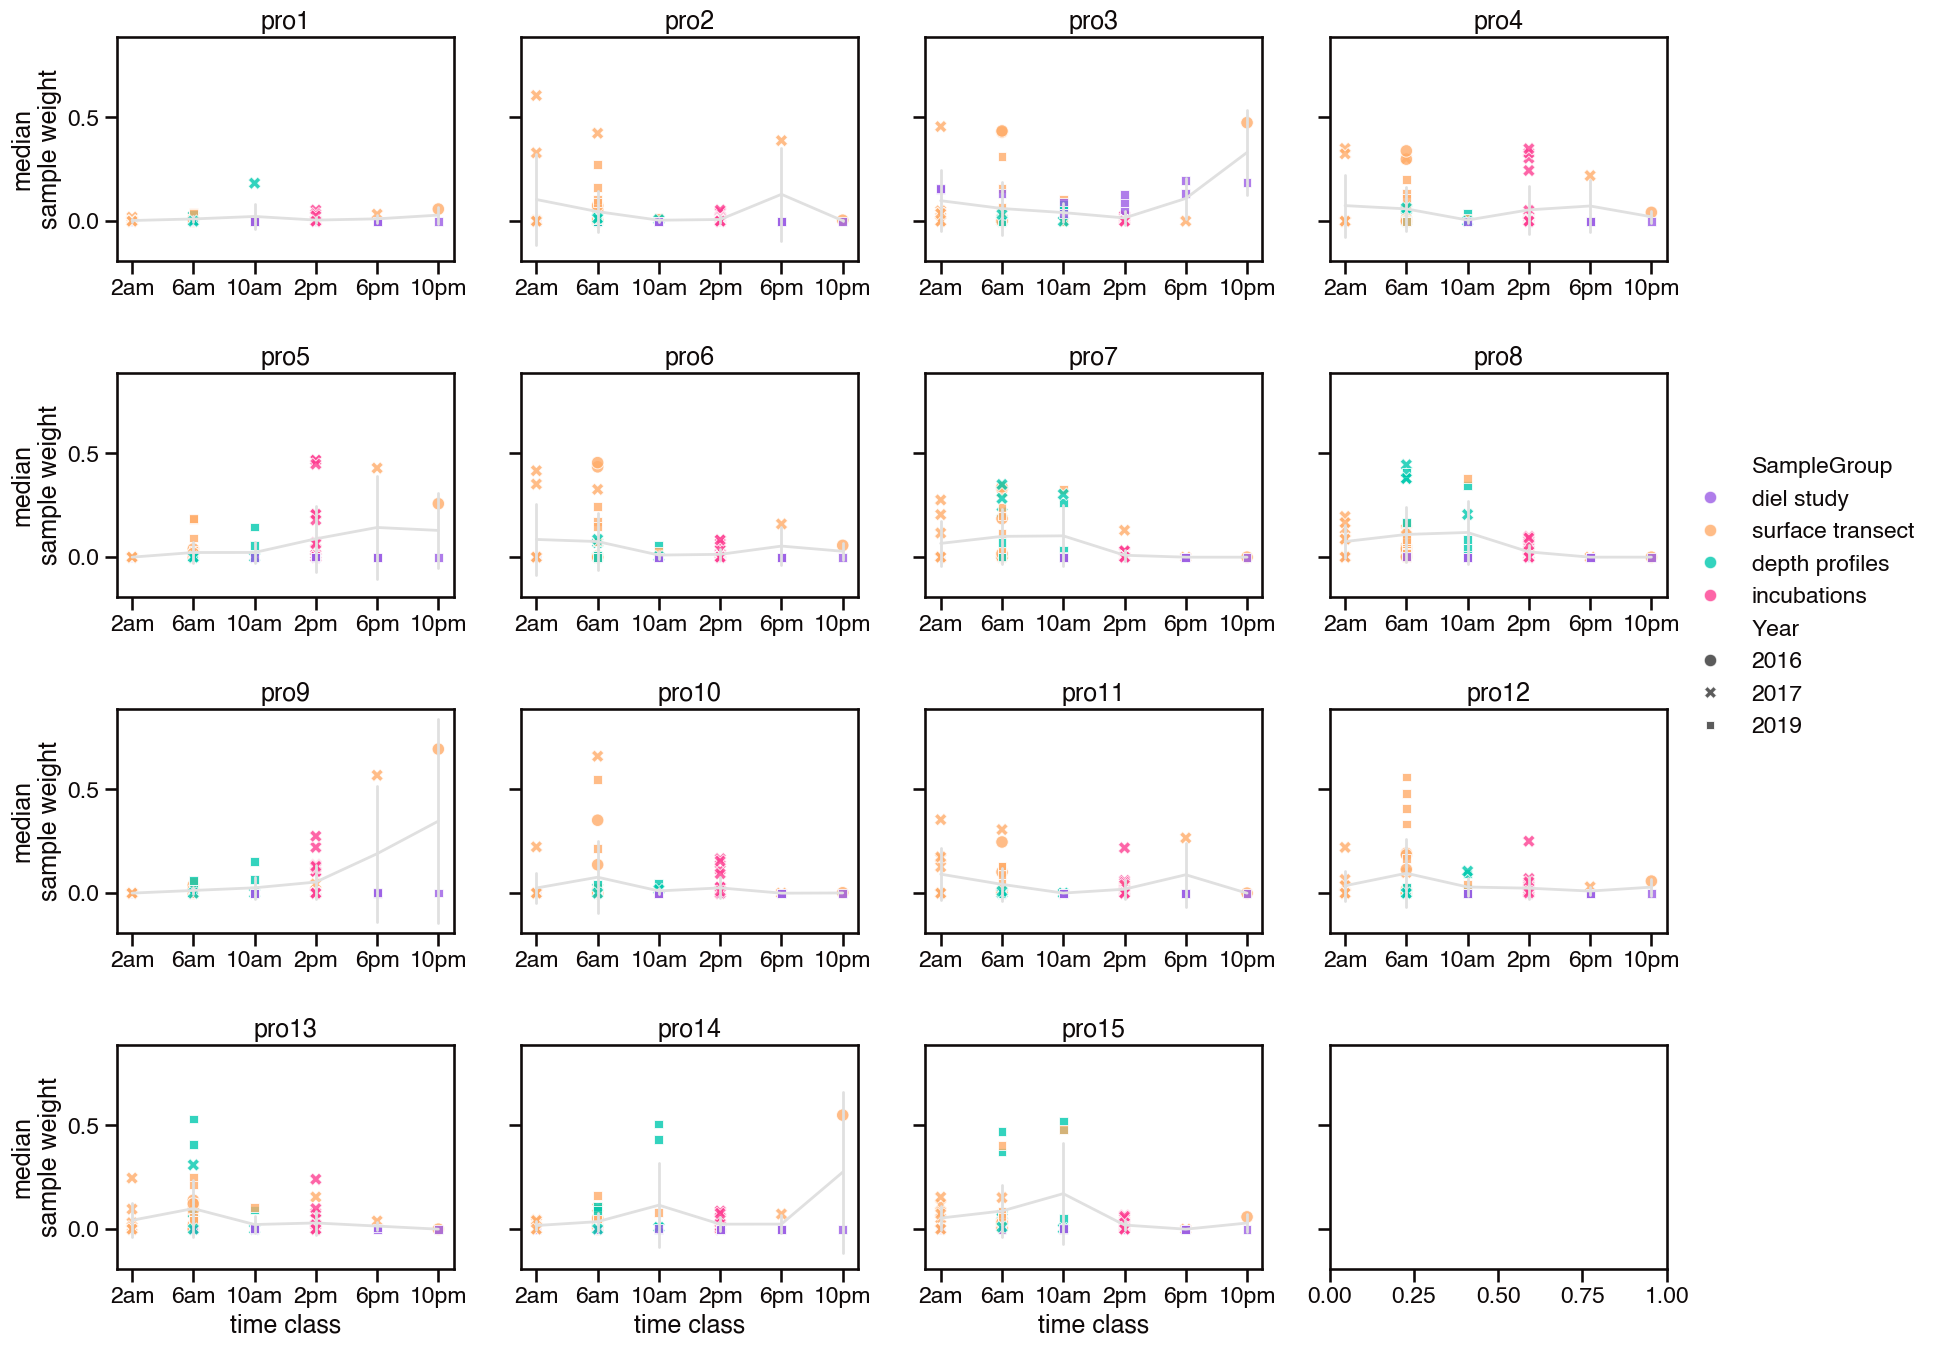

In [12]:
# plot each cluster's diel profile in pro data

# set up figure
rows = 5
cols = 3
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
fig, axes = plt.subplots(
    rows, cols, figsize=(20, 16), sharex=False, sharey=True, gridspec_kw={'hspace': 0.5, 'wspace': 0.2}
)

# set up data
pro_sample_df = pro_ds.SampleWeight.median(dim=['Bootstrap', 'Replicate']).to_series().reset_index()
pro_sample_df = pd.merge(
    pro_sample_df, 
    sample_df[['SampleName', 'TimeClass', 'TimeFraction', 'Datetime', 'Dataset', 'SampleGroup', 'Year']], 
    on='SampleName', how='left'
).sort_values('TimeFraction')

# plot each component
for i, component in enumerate(pro_clusters):
    row = i // cols
    col = i % cols
    axis = axes[row][col]
    plot_df = pro_sample_df[pro_sample_df['Component'] == component]
#     # drop all but surface samples
#     plot_df = plot_df[plot_df['samplegroup'].isin(['surface transect', 'diel study'])]
    sns.lineplot(
        data=plot_df, 
        x='TimeClass', 
        y='SampleWeight', 
        err_style='bars', 
        errorbar='sd', 
        color=neutral_color, 
        ax=axis, 
        legend=False
    )
    sns.scatterplot(
        data=plot_df, 
        x='TimeClass', 
        y='SampleWeight',
        hue='SampleGroup', 
        style='Year', 
        zorder=1, 
        alpha=0.8, 
        ax=axis, 
        legend=((row == 1) & (col == (cols - 1)))
    )
    # set legend location
    if ((row == 1) & (col == (cols - 1))):
        axis.legend(loc='center left', bbox_to_anchor=[1, 0])
    # set labels and such
    if row == (rows - 1):
        xlabel = 'time class'
    else:
        xlabel = ''
    if col == 0:
        ylabel = 'median\nsample weight'
    else:
        ylabel = ''
    axis.set(xlabel=xlabel, ylabel=ylabel, title='pro{}'.format(component))

# # save figure
# fig.savefig('pro-diel-peaks.png', bbox_inches='tight')


# _Synechococcus_

## Rolling mean with day timecourse

/var/folders/w0/7pz54fg92csc1bv996cgrss80000gn/T/ipykernel_90810/1241455319.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  syn_sample_df['Time'] = pd.to_datetime(syn_sample_df['Datetime']).dt.time


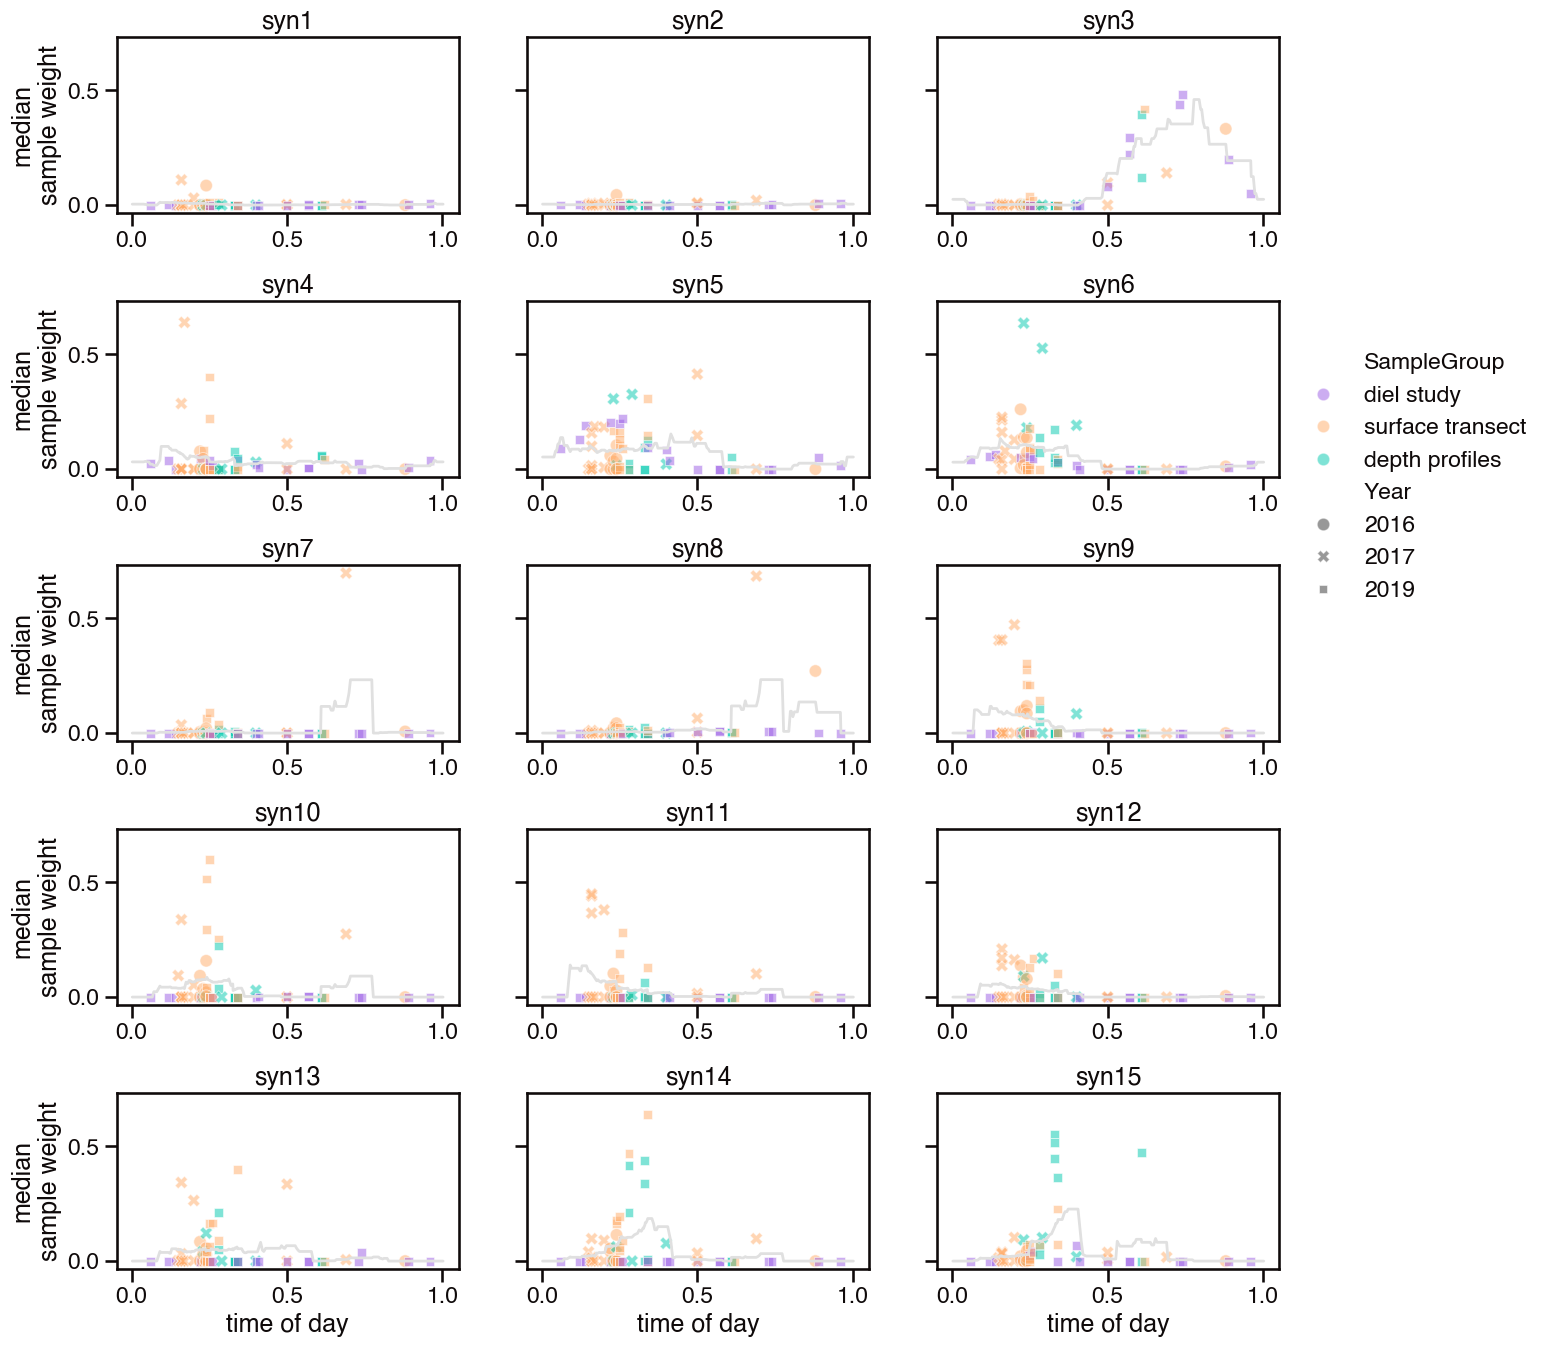

In [50]:
# plot each cluster's diel profile in pro data

# set up figure
rows = 5
cols = 3
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
fig, axes = plt.subplots(
    rows, cols, figsize=(15, 16), sharex=False, sharey=True, gridspec_kw={'hspace': 0.5, 'wspace': 0.2}
)

# set up data
syn_sample_df = syn_ds.SampleWeight.median(dim=['Bootstrap', 'Replicate']).to_series().reset_index()
syn_sample_df = pd.merge(
    syn_sample_df, 
    sample_df[['SampleName', 'TimeClass', 'TimeFraction', 'Datetime', 'Dataset', 'SampleGroup', 'Year']], 
    on='SampleName', how='left'
).sort_values('TimeFraction')
syn_sample_df['Time'] = pd.to_datetime(syn_sample_df['Datetime']).dt.time
syn_sample_df['standard_datetime'] = pd.to_datetime('9-18-1991 ' + syn_sample_df['Time'].astype(str))

# set up padding
n_min = 5
n_pts = 4320 // n_min + 1
pad_df = pd.DataFrame(
    {'standard_datetime': pd.date_range('1991-09-17', '1991-09-20', freq=f"{n_min}min"), 
     'TimeFraction': np.linspace(-1, 2, num=n_pts), 
     'SampleWeight': np.tile(np.nan, n_pts)}, 
)

# plot each component
for i in range(rows * cols):
    row = i // cols
    col = i % cols
    axis = axes[row][col]
    if i < len(syn_clusters):
        component = syn_clusters[i]
    else:
        # remove subplot
        fig.delaxes(axis)
    # select data
    plot_df = syn_sample_df[syn_sample_df['Component'] == component]
    # drop incubations
    plot_df = plot_df[plot_df['SampleGroup'].isin(['surface transect', 'diel study', 'depth profiles'])]
#     sns.lineplot(
#         data=plot_df, 
#         x='timefraction', 
#         y='sampleweights', 
#         err_style='bars', 
#         errorbar='sd', 
#         color=neutral_color, 
#         ax=axis, 
#         legend=False
#     )
#     sns.boxplot(
#         data=plot_df, 
#         x='timeclass', 
#         y='sampleweights', 
#         color=neutral_color, 
#         ax=axis, 
#     )
#     sns.kdeplot(
#         data=plot_df, 
#         x='timefraction', 
#         y='sampleweights', 
#         color=neutral_color, 
#         ax=axis
#     )
    # duplicate data and set as day before and after to provide padding
    day_before_df = plot_df.copy()
    day_before_df['standard_datetime'] = plot_df['standard_datetime'] - pd.Timedelta(days=1)
    day_before_df['TimeFraction'] = plot_df['TimeFraction'] - 1
    day_after_df = plot_df.copy()
    day_after_df['standard_datetime'] = plot_df['standard_datetime'] + pd.Timedelta(days=1)
    day_after_df['TimeFraction'] = plot_df['TimeFraction'] + 1
    # concatenate into one datetime df and sort by time of day
    dt_df = pd.concat([day_before_df, plot_df, day_after_df, pad_df]).set_index('standard_datetime').sort_index()
    # calculate rolling average
    dt_df = dt_df[['TimeFraction', 'SampleWeight']].rolling('4H', center=True).mean()
#     dt_df['sampleweights'] = dt_df['sampleweights'].rolling('4H', center=True).mean()
#     dt_df = dt_df[['timefraction', 'sampleweights']].rolling(window, min_periods=window, center=True).mean()
    # cut out just the center (padded) day
    dt_df = dt_df[len(dt_df)//3:2*len(dt_df)//3+1]
    sns.lineplot(
        data=dt_df, 
        x='TimeFraction', 
        y='SampleWeight', 
        err_style=None, 
        color=neutral_color, 
        ax=axis, 
        legend=False
    )
    sns.scatterplot(
        data=plot_df, 
        x='TimeFraction', 
        y='SampleWeight',
        hue='SampleGroup', 
        style='Year', 
        zorder=1, 
        alpha=0.5, 
        ax=axis, 
        legend=((row == 1) & (col == (cols - 1)))
    )
    # set legend location
    if ((row == 1) & (col == (cols - 1))):
        axis.legend(loc='center left', bbox_to_anchor=[1, 0])
    # set labels and such
    if len(syn_clusters)-cols <= i < len(syn_clusters):
        xlabel = 'time of day'
    else:
        xlabel = ''
    if col == 0:
        ylabel = 'median\nsample weight'
    else:
        ylabel = ''
    axis.set(xlabel=xlabel, ylabel=ylabel, title='syn{}'.format(component))
    
# save figure
fig.savefig('syn-diel-peaks.png', bbox_inches='tight')


# weighted kde

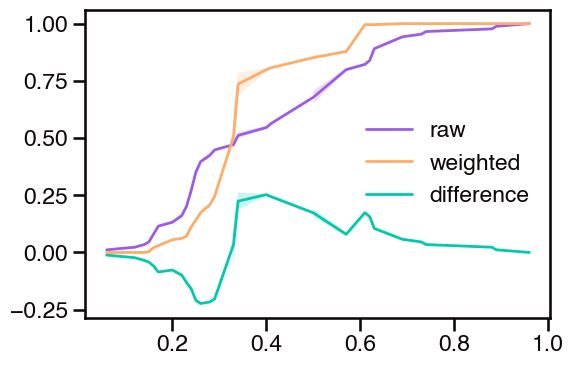

In [37]:
fig, ax = plt.subplots(figsize=(6, 4))

estimator = sns.distributions.ECDF()
raw_stat, vals = estimator(plot_df['TimeFraction'], weights=None)
weight_stat, vals = estimator(plot_df['TimeFraction'], weights=plot_df['SampleWeight'])
diff_stat = weight_stat - raw_stat

for i, stat in enumerate([raw_stat, weight_stat, diff_stat]):
    sns.lineplot(x=vals, y=stat, label=['raw', 'weighted', 'difference'][i], ax=ax)


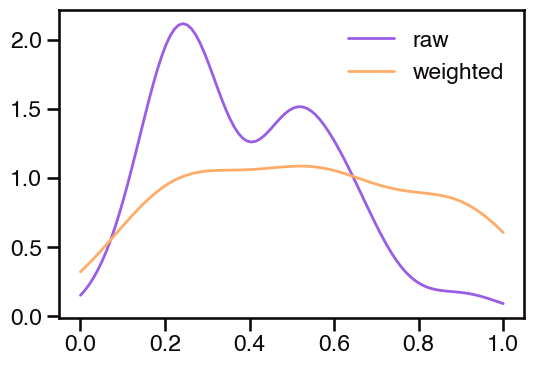

In [47]:
fig, ax = plt.subplots(figsize=(6, 4))

raw_kernel = gaussian_kde(plot_df['TimeFraction'])
weighted_kernel = gaussian_kde(plot_df['TimeFraction'], weights=(1 / raw_kernel(plot_df['TimeFraction'])))
values = np.linspace(0, 1, num=100)

for i, kernel in enumerate([raw_kernel, weighted_kernel]):
    sns.lineplot(x=values, y=kernel(values), label=['raw', 'weighted'][i], ax=ax)
    
# diff = weighted_kernel(values) - raw_kernel(values)
# sns.lineplot(x=values, y=diff, label='diff', ax=ax)
    

In [73]:
count, edges = np.histogram(plot_df['TimeFraction'], bins=6, range=(0, 1))
1 / count


array([0.11111111, 0.03030303, 0.14285714, 0.03125   , 0.33333333,
       0.33333333])

<Axes: >

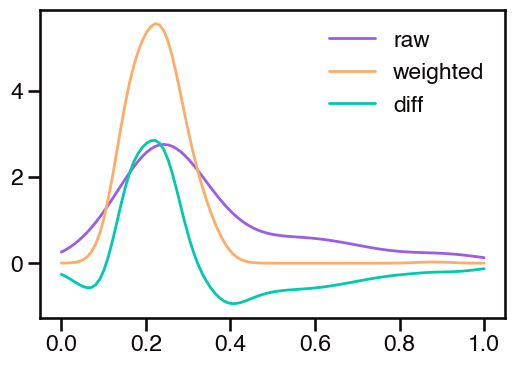

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))

raw_kernel = gaussian_kde(plot_df['TimeFraction'])
weighted_kernel = gaussian_kde(plot_df['TimeFraction'], weights=plot_df['SampleWeight'])
values = np.linspace(0, 1, num=100)

for i, kernel in enumerate([raw_kernel, weighted_kernel]):
    sns.lineplot(x=values, y=kernel(values), label=['raw', 'weighted'][i], ax=ax)
    
diff = weighted_kernel(values) - raw_kernel(values)
sns.lineplot(x=values, y=diff, label='diff', ax=ax)
    

1: kde max at 6:03
2: kde max at 19:23
3: kde max at 20:07
4: kde max at 6:32
5: kde max at 6:18
6: kde max at 5:49
7: kde max at 16:00
8: kde max at 18:25
9: kde max at 5:05
10: kde max at 5:49
11: kde max at 4:36
12: kde max at 5:20
13: kde max at 6:03
14: kde max at 7:01
15: kde max at 7:45


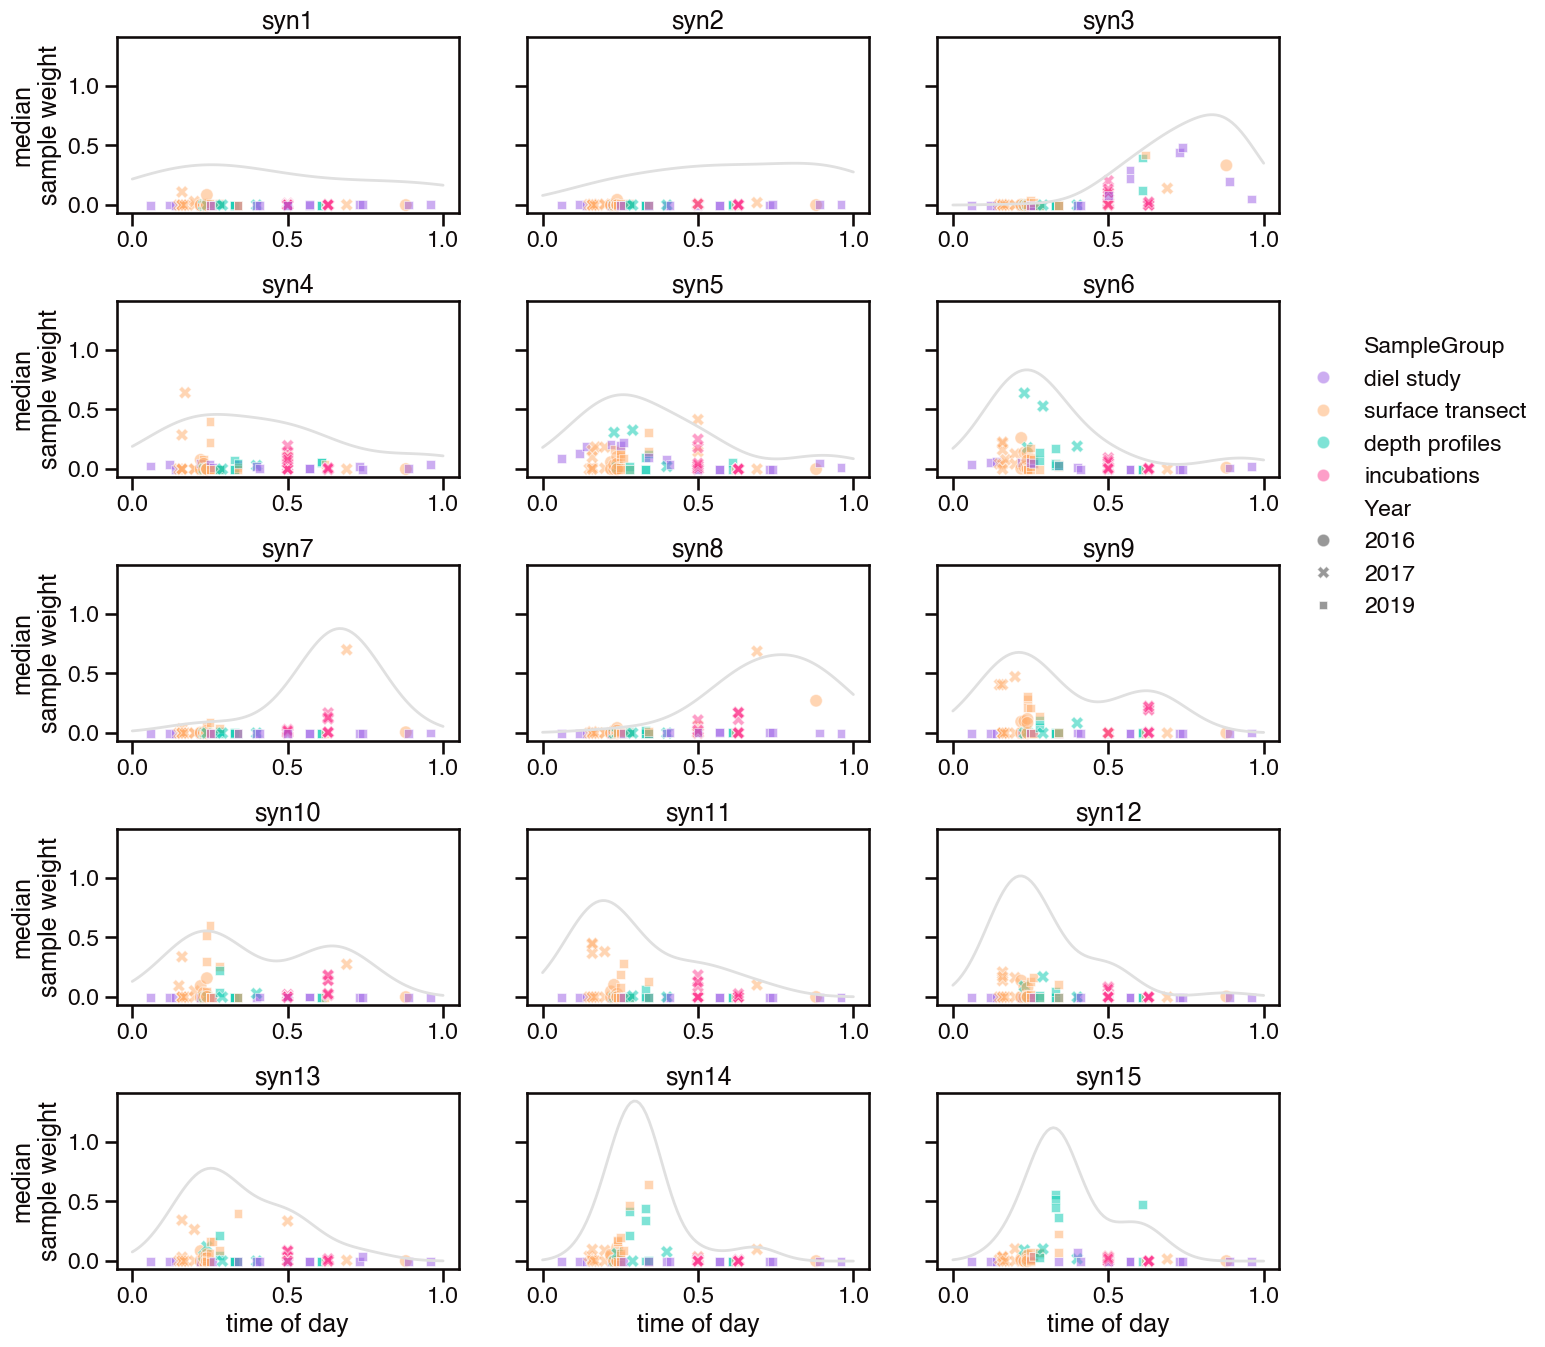

In [52]:
# plot each cluster's diel profile in pro data

# set up figure
rows = 5
cols = 3
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
fig, axes = plt.subplots(
    rows, cols, figsize=(15, 16), sharex=False, sharey=True, gridspec_kw={'hspace': 0.5, 'wspace': 0.2}
)

# set up data
syn_sample_df = syn_ds.SampleWeight.median(dim=['Bootstrap', 'Replicate']).to_series().reset_index()
syn_sample_df = pd.merge(
    syn_sample_df, 
    sample_df[['SampleName', 'TimeClass', 'TimeFraction', 'Datetime', 'Dataset', 'SampleGroup', 'Year']], 
    on='SampleName', how='left'
).sort_values('TimeFraction')

# plot each component
for i in range(rows * cols):
    row = i // cols
    col = i % cols
    axis = axes[row][col]
    if i < len(syn_clusters):
        component = syn_clusters[i]
    else:
        # remove subplot
        fig.delaxes(axis)
    # select data
    plot_df = syn_sample_df[syn_sample_df['Component'] == component]
    # calculate weighted kde
    raw_kernel = gaussian_kde(plot_df['TimeFraction'])
    weighted_kernel = gaussian_kde(plot_df['TimeFraction'], weights=(plot_df['SampleWeight'] * (1 / raw_kernel(plot_df['TimeFraction']))))
    values = np.linspace(0, 1, num=100)
    diff = weighted_kernel(values) - raw_kernel(values)
    sns.lineplot(
        x=values, 
        y=weighted_kernel(values) / 3, 
        err_style=None, 
        color=neutral_color, 
        ax=axis, 
        legend=False
    )
    hour = 24 * values[np.argmax(weighted_kernel(values))]
    print(f"{component}: kde max at {int(hour)}:{int(hour % 1 * 60):02}")
    sns.scatterplot(
        data=plot_df, 
        x='TimeFraction', 
        y='SampleWeight',
        hue='SampleGroup', 
        style='Year', 
        zorder=1, 
        alpha=0.5, 
        ax=axis, 
        legend=((row == 1) & (col == (cols - 1)))
    )
    # set legend location
    if ((row == 1) & (col == (cols - 1))):
        axis.legend(loc='center left', bbox_to_anchor=[1, 0])
    # set labels and such
    if len(syn_clusters)-cols <= i < len(syn_clusters):
        xlabel = 'time of day'
    else:
        xlabel = ''
    if col == 0:
        ylabel = 'median\nsample weight'
    else:
        ylabel = ''
    axis.set(xlabel=xlabel, ylabel=ylabel, title='syn{}'.format(component))
    
# save figure
fig.savefig('syn-diel-peaks.png', bbox_inches='tight')


# Spline

In [19]:
from scipy.interpolate import splrep, BSpline

1: kde max at 0:00
2: kde max at 24:00
3: kde max at 20:50
4: kde max at 0:00
5: kde max at 5:34
6: kde max at 4:36
7: kde max at 0:00
8: kde max at 19:52
9: kde max at 0:00
10: kde max at 0:00
11: kde max at 0:00
12: kde max at 1:56
13: kde max at 6:47
14: kde max at 24:00
15: kde max at 8:14


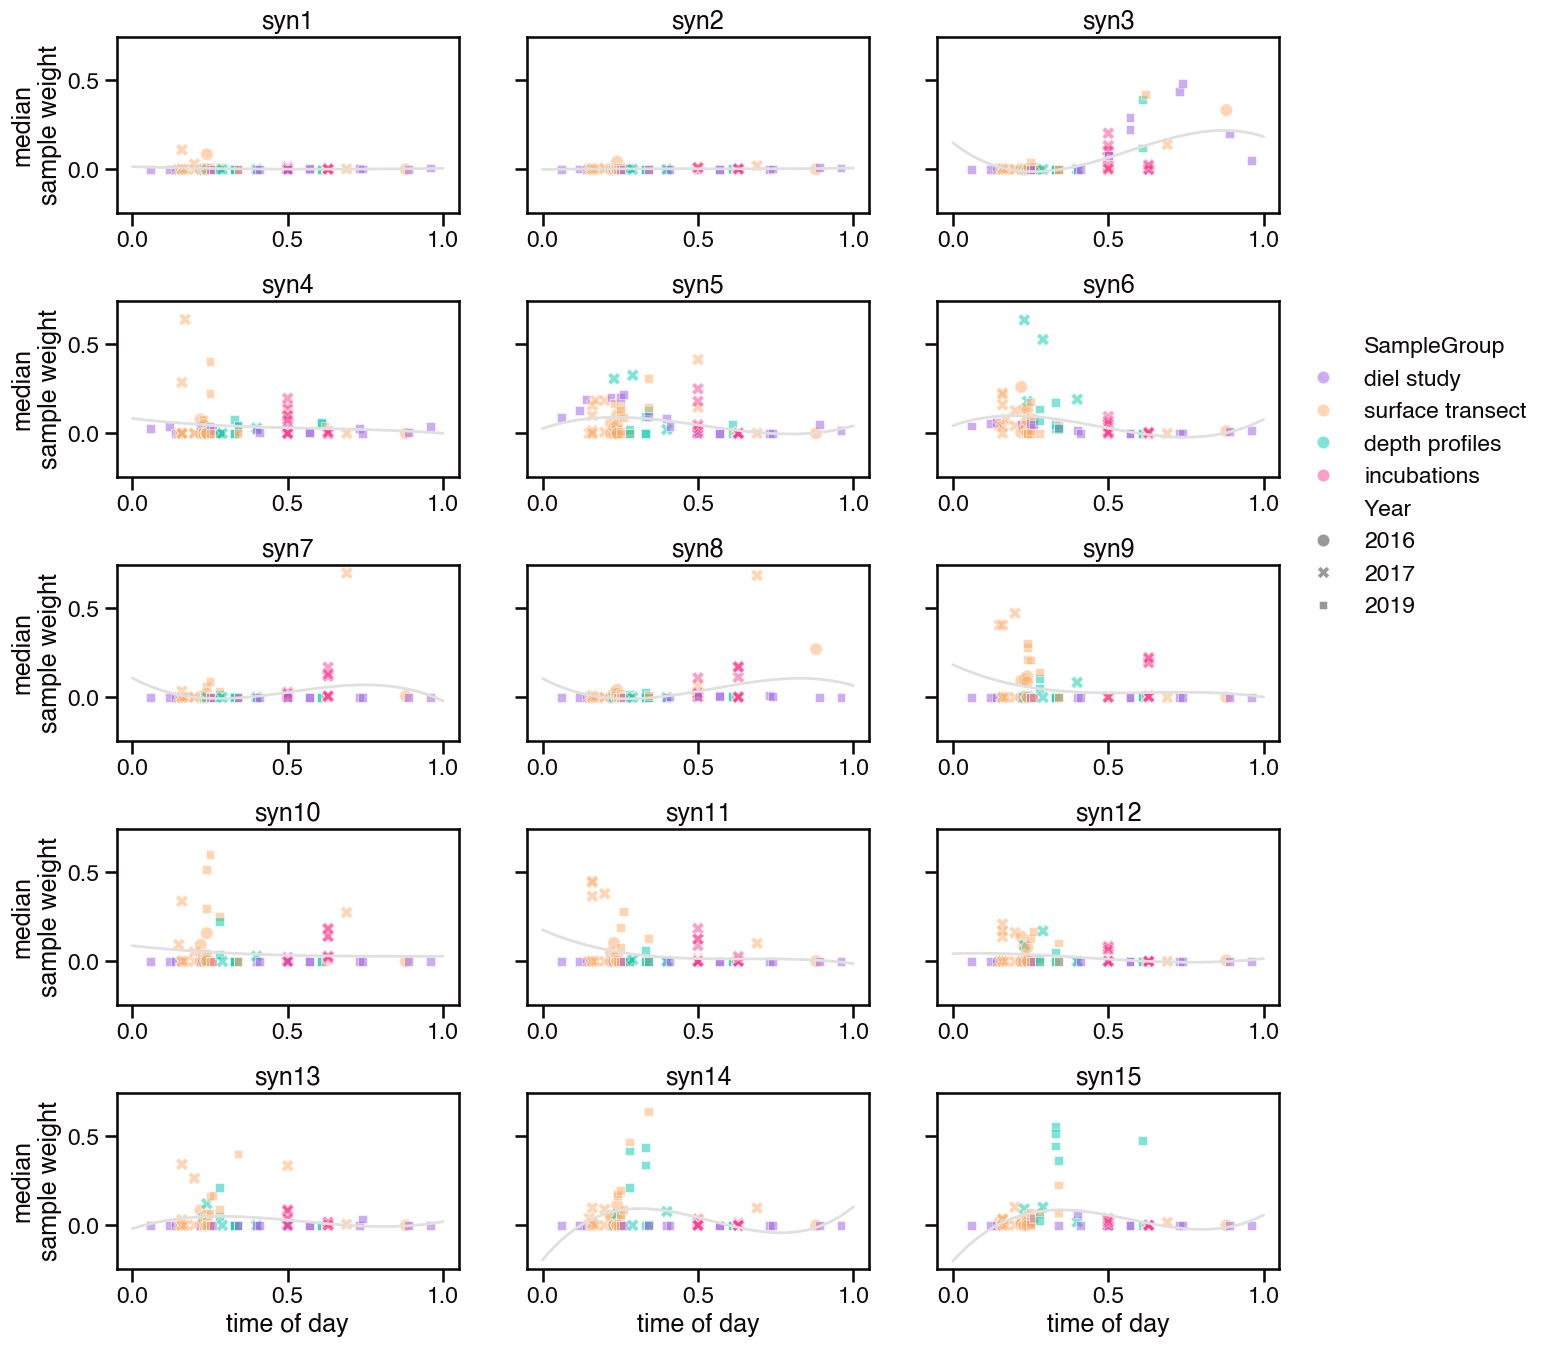

In [25]:
# plot each cluster's diel profile in pro data

# set up figure
rows = 5
cols = 3
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
fig, axes = plt.subplots(
    rows, cols, figsize=(15, 16), sharex=False, sharey=True, gridspec_kw={'hspace': 0.5, 'wspace': 0.2}
)

# set up data
syn_sample_df = syn_ds.SampleWeight.median(dim=['Bootstrap', 'Replicate']).to_series().reset_index()
syn_sample_df = pd.merge(
    syn_sample_df, 
    sample_df[['SampleName', 'TimeClass', 'TimeFraction', 'Datetime', 'Dataset', 'SampleGroup', 'Year']], 
    on='SampleName', how='left'
).sort_values('TimeFraction')

# plot each component
for i in range(rows * cols):
    row = i // cols
    col = i % cols
    axis = axes[row][col]
    if i < len(syn_clusters):
        component = syn_clusters[i]
    else:
        # remove subplot
        fig.delaxes(axis)
    # select data
    plot_df = syn_sample_df[syn_sample_df['Component'] == component]
    # calculate spline 
    tck = splrep(plot_df['TimeFraction'], plot_df['SampleWeight'], s=80)
    spline = BSpline(*tck)
    values = np.linspace(0, 1, num=100)
    sns.lineplot(
        x=values, 
        y=spline(values),  
        err_style=None, 
        color=neutral_color, 
        ax=axis, 
        legend=False
    )
    hour = 24 * values[np.argmax(spline(values))]
    print(f"{component}: kde max at {int(hour)}:{int(hour % 1 * 60):02}")
    sns.scatterplot(
        data=plot_df, 
        x='TimeFraction', 
        y='SampleWeight',
        hue='SampleGroup', 
        style='Year', 
        zorder=1, 
        alpha=0.5, 
        ax=axis, 
        legend=((row == 1) & (col == (cols - 1)))
    )
    # set legend location
    if ((row == 1) & (col == (cols - 1))):
        axis.legend(loc='center left', bbox_to_anchor=[1, 0])
    # set labels and such
    if len(syn_clusters)-cols <= i < len(syn_clusters):
        xlabel = 'time of day'
    else:
        xlabel = ''
    if col == 0:
        ylabel = 'median\nsample weight'
    else:
        ylabel = ''
    axis.set(xlabel=xlabel, ylabel=ylabel, title='syn{}'.format(component))
    
# save figure
fig.savefig('syn-diel-peaks.png', bbox_inches='tight')


In [23]:
values

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [22]:
spline(values)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

# TODO:

- Chunk everything out separately
- Try Savitzky-Golay filter
    - https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
- Try spline
    - https://docs.scipy.org/doc/scipy/tutorial/interpolate/smoothing_splines.html

### actually

- weights vs. time fraction
- lineplot of weights binned by time class
    - just diel weights in those with clear signature
    - all weights in rest
    - mean with sd or median with quartiles
    - also potentially leave out nonzero


